# 로보틱스 트렌딩 저장소 찾기

이 노트북은 **최근 90일 동안 가장 많은 별점을 받은 상위 100개 로보틱스 저장소**를 찾습니다.

**주요 기능:**
- `topic` 및/또는 `description` 키워드로 검색
- GitHub의 1,000개 결과 제한을 피하기 위한 pushed-date 윈도우 샤딩
- stargazers API를 사용한 최근 별점 카운팅
- ROS2 공식 저장소 포함 (description 매칭)

**생성일:** 2025-10-30

## 1. 설정 및 구성

In [29]:
# Required imports
import os, time, datetime as dt
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from tqdm import tqdm
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# GitHub API Configuration
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")
if not GITHUB_TOKEN:
    raise ValueError("GitHub token required! Set GITHUB_TOKEN in .env file")

SESSION = requests.Session()
SESSION.headers.update({
    "Accept": "application/vnd.github+json",
    "Authorization": f"Bearer {GITHUB_TOKEN}",
    "X-GitHub-Api-Version": "2022-11-28",
    "User-Agent": "trending-robotics/1.0"
})

# API Endpoints
API_BASE = "https://api.github.com"
SEARCH_API = f"{API_BASE}/search/repositories"
STARS_API = f"{API_BASE}/repos/{{owner}}/{{repo}}/stargazers"

# ═══════════════════════════════════════════════════════════════
# Search Configuration - MODIFY THESE TO CHANGE SEARCH BEHAVIOR
# ═══════════════════════════════════════════════════════════════
TOPIC = "robot"                    # GitHub topic to search
DESCRIPTION_KEYWORD = "robot"       # Keyword in description (set None to disable)
                                    # Examples: "robotics", "ROS2", "autonomous"

DAYS_WINDOW = 90                    # Days of recent stars to analyze
PUSH_WINDOW_DAYS = 365              # Days of pushed activity (1 year to include legacy projects)
MIN_STARS = 100                     # Minimum total stars to consider (filters low-quality repos)
TOP_N = 100                         # Number of top repos to return
VISUALIZE_TOP_N = 30                # Number of repos to visualize

# ═══════════════════════════════════════════════════════════════
# API & Performance Settings
# ═══════════════════════════════════════════════════════════════
RESULTS_PER_PAGE = 100              # Max results per API page
SLEEP_TIME = 2                      # Seconds between API calls
PUSH_BUCKET_DAYS = 30               # Days per pushed-date window (increased for 1-year range)
MAX_RETRIES = 3                     # Max retries for failed API calls

print("✅ Configuration loaded")
print(f"   Topic: {TOPIC}")
print(f"   Description Keyword: {DESCRIPTION_KEYWORD}")
print(f"   Star Analysis Window: Last {DAYS_WINDOW} days")
print(f"   Pushed Activity Window: Last {PUSH_WINDOW_DAYS} days")
print(f"   Minimum Stars: {MIN_STARS}")
print(f"   Target: Top {TOP_N} repositories")


✅ Configuration loaded
   Topic: robot
   Description Keyword: robot
   Star Analysis Window: Last 90 days
   Pushed Activity Window: Last 365 days
   Minimum Stars: 100
   Target: Top 100 repositories


## 2. 헬퍼 함수

In [30]:
def github_api_call(url: str, params: dict = None, headers: dict = None, max_retries: int = 3) -> dict:
    """GitHub API 호출 with rate limit handling and retries"""
    retries = 0
    while retries < max_retries:
        try:
            resp = SESSION.get(url, params=params, headers=headers, timeout=30)
            
            # Rate limit check
            if resp.status_code == 403 and "X-RateLimit-Remaining" in resp.headers:
                reset_time = int(resp.headers["X-RateLimit-Reset"])
                sleep_time = max(reset_time - time.time() + 1, 1)
                print(f"⏳ Rate limit hit. Waiting {sleep_time:.0f}s...")
                time.sleep(sleep_time)
                continue
                
            resp.raise_for_status()
            return resp.json()
            
        except Exception as e:
            retries += 1
            if retries >= max_retries:
                print(f"❌ Max retries exceeded for {url}: {str(e)}")
                return {}
            print(f"⚠️  API error (retry {retries}/{max_retries}): {str(e)}")
            time.sleep(5)
    
    return {}


def get_recent_stars(owner: str, repo: str, since_date: str, max_pages: int = None) -> int:
    """
    GraphQL API로 최근 별점만 역순 페이지네이션으로 조회
    REST API의 400페이지 한계를 우회하여 최근 데이터에 직접 접근
    
    Args:
        owner: 저장소 소유자
        repo: 저장소 이름
        since_date: 기준 날짜 (ISO 8601)
        max_pages: 최대 페이지 수 (None=제한 없음, 90일 이전까지 전부 수집)
    
    Returns:
        최근 90일 이내 별점 수
    """
    
    # GraphQL 쿼리: 역순 페이지네이션 (최신부터)
    query = """
    query($owner: String!, $repo: String!, $last: Int!, $before: String) {
      repository(owner: $owner, name: $repo) {
        stargazers(last: $last, before: $before) {
          edges {
            starredAt
            cursor
          }
          pageInfo {
            hasPreviousPage
            startCursor
          }
        }
      }
    }
    """
    
    headers = {
        "Authorization": f"token {GITHUB_TOKEN}",
        "Content-Type": "application/json"
    }
    
    graphql_url = "https://api.github.com/graphql"
    
    recent_count = 0
    before_cursor = None
    found_old_star = False
    page = 0
    
    while True:
        page += 1
        
        # max_pages 제한이 있으면 체크
        if max_pages and page > max_pages:
            break
        
        # 안전장치: 최대 200페이지 (20,000개)
        if page > 200:
            break
        
        variables = {
            "owner": owner,
            "repo": repo,
            "last": 100,  # GraphQL 한계
            "before": before_cursor
        }
        
        try:
            response = SESSION.post(
                graphql_url,
                json={"query": query, "variables": variables},
                headers=headers,
                timeout=30
            )
            
            if response.status_code == 200:
                data = response.json()
                
                if "errors" in data:
                    # GraphQL 에러 발생 시 조용히 0 반환 (신규 저장소일 수 있음)
                    return 0
                
                stargazers = data.get("data", {}).get("repository", {}).get("stargazers", {})
                edges = stargazers.get("edges", [])
                page_info = stargazers.get("pageInfo", {})
                
                if not edges:
                    break
                
                # 현재 페이지의 최근 별점 카운트
                for edge in edges:
                    starred_at = edge.get("starredAt", "")
                    if starred_at >= since_date:
                        recent_count += 1
                    else:
                        found_old_star = True
                
                # 90일 이전 별점을 만나면 중단 (더 이상 최근 별점 없음)
                if found_old_star:
                    break
                
                # 이전 페이지가 없으면 종료
                if not page_info.get("hasPreviousPage"):
                    break
                
                # 다음 페이지 커서
                before_cursor = page_info.get("startCursor")
                time.sleep(1)  # Rate limit 방지
                
            elif response.status_code == 429:
                # Rate limit 대기
                time.sleep(60)
            else:
                break
                
        except Exception as e:
            break
    
    return recent_count


def daterange(start: dt.date, end: dt.date, step_days: int):
    """Generate date ranges for sharding"""
    cur = start
    delta = dt.timedelta(days=step_days-1)
    while cur <= end:
        window_end = min(end, cur + delta)
        yield cur, window_end
        cur = window_end + dt.timedelta(days=1)


def iso_date(d: dt.date) -> str:
    """Convert date to ISO format"""
    return d.isoformat()


print("✅ Helper functions defined")

✅ Helper functions defined


## 3. 저장소 검색

이 섹션은 다음을 사용하여 GitHub 저장소를 검색합니다:
- **토픽 기반 검색**: `topic:{TOPIC}`
- **Description 검색** (선택): `{DESCRIPTION_KEYWORD} in:description`
- **Pushed-date 샤딩**: GitHub의 1,000개 결과 제한 회피

In [31]:
# Calculate time windows
since_date = (dt.datetime.utcnow() - dt.timedelta(days=DAYS_WINDOW)).isoformat()
end_date = dt.date.today()
start_date = end_date - dt.timedelta(days=PUSH_WINDOW_DAYS-1)

# Build pushed-date windows
windows = list(daterange(start_date, end_date, PUSH_BUCKET_DAYS))

print(f"🔍 Searching repositories...")
print(f"   Pushed window: {start_date} to {end_date} ({len(windows)} shards)")
print(f"   Star counting since: {since_date[:10]}")
print(f"   Minimum stars: {MIN_STARS}\n")

# Build search query with minimum stars filter
if DESCRIPTION_KEYWORD:
    query_template = f'(topic:{TOPIC} OR ({DESCRIPTION_KEYWORD} in:description)) stars:>={MIN_STARS} pushed:{{start}}..{{end}}'
    print(f"   Query: (topic:{TOPIC} OR {DESCRIPTION_KEYWORD} in description) AND stars >= {MIN_STARS}")
else:
    query_template = f'topic:{TOPIC} stars:>={MIN_STARS} pushed:{{start}}..{{end}}'
    print(f"   Query: topic:{TOPIC} AND stars >= {MIN_STARS}")

# Search repositories across all windows
all_repos = {}

for start, end in windows:
    query = query_template.format(start=iso_date(start), end=iso_date(end))
    page = 1
    
    while page <= 10:  # Max 10 pages per window (1,000 results)
        resp = github_api_call(
            SEARCH_API,
            params={
                "q": query,
                "sort": "stars",
                "order": "desc",
                "per_page": RESULTS_PER_PAGE,
                "page": page
            }
        )
        
        if not resp or "items" not in resp:
            break
            
        repos = resp["items"]
        if not repos:
            break
            
        # Add repos (dict for deduplication)
        for repo in repos:
            all_repos[repo["full_name"]] = repo
            
        if page * RESULTS_PER_PAGE >= 1000:
            break
            
        page += 1
        time.sleep(SLEEP_TIME)

print(f"\n✅ Found {len(all_repos):,} unique repositories (stars >= {MIN_STARS})")


/tmp/ipykernel_117820/2095012545.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  since_date = (dt.datetime.utcnow() - dt.timedelta(days=DAYS_WINDOW)).isoformat()


🔍 Searching repositories...
   Pushed window: 2024-10-31 to 2025-10-30 (13 shards)
   Star counting since: 2025-08-01
   Minimum stars: 100

   Query: (topic:robot OR robot in description) AND stars >= 100

✅ Found 676 unique repositories (stars >= 100)

✅ Found 676 unique repositories (stars >= 100)


## 4. 최근 별점 카운팅

각 저장소에 대해 stargazers API를 사용하여 최근 {DAYS_WINDOW}일 동안 추가된 별점을 카운팅합니다.

In [32]:
print(f"⭐ Counting recent stars for {len(all_repos):,} repositories...")
print(f"⚠️  예상 소요 시간: 약 30-60분 (무제한 수집)")
print("=" * 80)
print()

trending = []

for repo in tqdm(all_repos.values(), desc="Processing repos"):
    owner, name = repo["full_name"].split("/")
    
    # max_pages=None으로 무제한 수집 (90일 이전까지 전부)
    recent_stars = get_recent_stars(owner, name, since_date, max_pages=None)
    
    if recent_stars > 0:
        # Use max() to handle cases where stars were added during collection
        # This prevents recent_stars > total_stars timing issues
        total_stars = max(repo["stargazers_count"], recent_stars)
        
        trending.append({
            "full_name": repo["full_name"],
            "description": repo["description"],
            "language": repo["language"],
            "total_stars": total_stars,
            "recent_stars": recent_stars,
            "url": repo["html_url"],
            "topics": ",".join(repo.get("topics", []))
        })
        
    time.sleep(SLEEP_TIME)

# Sort and get top N
result_df = pd.DataFrame(trending)
result_df = result_df.sort_values("recent_stars", ascending=False).head(TOP_N)

print(f"\n✅ Completed! Top {TOP_N} repositories identified")
print(f"   Total with recent stars: {len(trending):,}")
print(f"   Average recent stars (top {TOP_N}): {result_df['recent_stars'].mean():.1f}")

⭐ Counting recent stars for 676 repositories...
⚠️  예상 소요 시간: 약 30-60분 (무제한 수집)



Processing repos: 100%|██████████| 676/676 [36:11<00:00,  3.21s/it]  


✅ Completed! Top 100 repositories identified
   Total with recent stars: 669
   Average recent stars (top 100): 352.5


## 5. 결과 저장

In [33]:
# Save to CSV
timestamp = dt.datetime.now().strftime("%Y%m%d_%H%M")
out_csv = f"robotics_trending_top{TOP_N}_{timestamp}.csv"

result_df.to_csv(out_csv, index=False, encoding="utf-8")
print(f"✅ Saved to: {out_csv}\n")

# Display top 10
print("=" * 80)
print(f"TOP 10 TRENDING REPOSITORIES (Last {DAYS_WINDOW} days)")
print("=" * 80)

for idx, repo in result_df.head(10).iterrows():
    print(f"\n{idx + 1}. {repo['full_name']}")
    print(f"   Recent stars: {repo['recent_stars']:,} | Total: {repo['total_stars']:,}")
    print(f"   Language: {repo['language'] or 'Not specified'}")
    if repo['description']:
        print(f"   {repo['description'][:100]}...")

✅ Saved to: robotics_trending_top100_20251030_1806.csv

TOP 10 TRENDING REPOSITORIES (Last 90 days)

539. commaai/openpilot
   Recent stars: 3,222 | Total: 58,657
   Language: Python
   openpilot is an operating system for robotics. Currently, it upgrades the driver assistance system o...

543. huggingface/lerobot
   Recent stars: 2,691 | Total: 18,836
   Language: Python
   🤗 LeRobot: Making AI for Robotics more accessible with end-to-end learning...

549. Vector-Wangel/XLeRobot
   Recent stars: 2,200 | Total: 3,976
   Language: Python
   XLeRobot: Practical Dual-Arm Mobile Home Robot for $660...

540. mudler/LocalAI
   Recent stars: 2,102 | Total: 36,132
   Language: Go
   :robot: The free, Open Source alternative to OpenAI, Claude and others. Self-hosted and local-first....

142. ClemensElflein/OpenMower
   Recent stars: 1,401 | Total: 6,302
   Language: C++
   Let's upgrade cheap off-the-shelf robotic mowers to modern, smart RTK GPS based lawn mowing robots!...

562. OpenMind/OM1
 

## 6. 결과 시각화

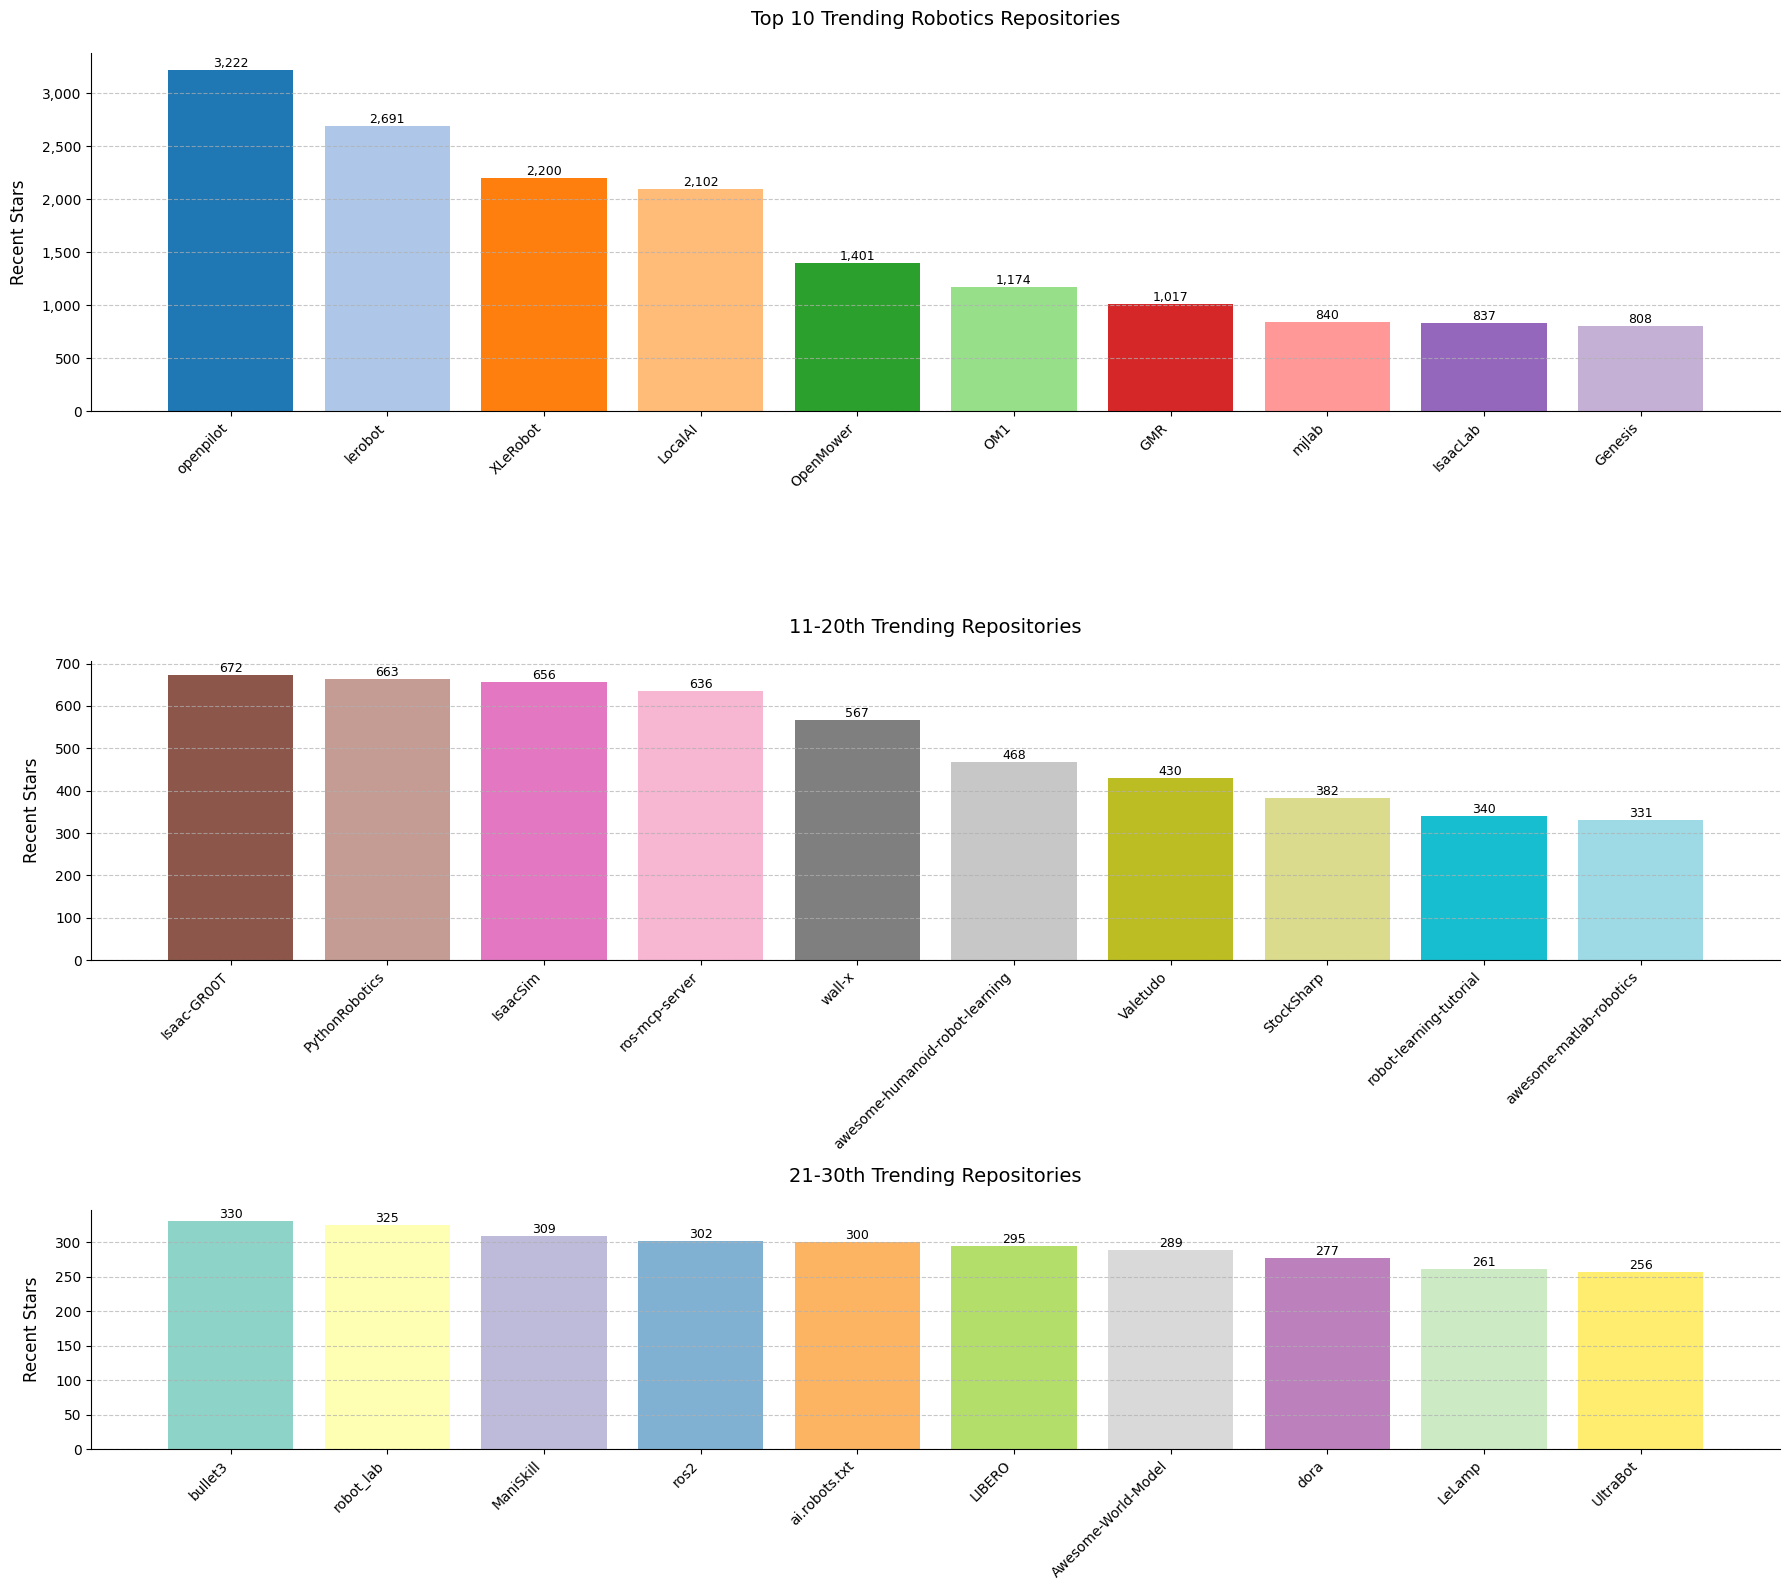


STATISTICS
Total recent stars (top 30): 24,381
Average: 812.7
Median: 517.5
Total cumulative stars: 243,965

Language Distribution (top 30):
  Python: 16 repos (53.3%)
  C++: 2 repos (6.7%)
  Jupyter Notebook: 2 repos (6.7%)
  Go: 1 repos (3.3%)
  JavaScript: 1 repos (3.3%)


In [34]:
# Prepare visualization data
top_n_df = result_df.head(VISUALIZE_TOP_N).copy()
top_n_df['repo_name'] = top_n_df['full_name'].apply(lambda x: x.split('/')[-1])

# Setup matplotlib
plt.rcParams['figure.figsize'] = (18, 16)
plt.rcParams['font.size'] = 10

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, height_ratios=[3, 2.5, 2])

# Color palette
colors = plt.cm.tab20(np.linspace(0, 1, 20))
colors = np.vstack((colors, plt.cm.Set3(np.linspace(0, 1, 10))))

# Plot bars
bars1 = ax1.bar(range(10), top_n_df['recent_stars'].head(10), color=colors[:10])
bars2 = ax2.bar(range(10), top_n_df['recent_stars'].iloc[10:20], color=colors[10:20])
bars3 = ax3.bar(range(10), top_n_df['recent_stars'].iloc[20:30], color=colors[20:30])

# Titles
ax1.set_title('Top 10 Trending Robotics Repositories', fontsize=14, pad=20)
ax2.set_title('11-20th Trending Repositories', fontsize=14, pad=20)
ax3.set_title('21-30th Trending Repositories', fontsize=14, pad=20)

# Helper functions
def add_value_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height,
                f'{int(height):,}', ha='center', va='bottom', fontsize=9)

def setup_axes(ax, repos):
    ax.set_xticks(range(len(repos)))
    ax.set_xticklabels(repos, rotation=45, ha='right')
    ax.set_ylabel('Recent Stars', fontsize=12, labelpad=10)
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

# Apply formatting
add_value_labels(ax1, bars1)
add_value_labels(ax2, bars2)
add_value_labels(ax3, bars3)
setup_axes(ax1, top_n_df['repo_name'].head(10).tolist())
setup_axes(ax2, top_n_df['repo_name'].iloc[10:20].tolist())
setup_axes(ax3, top_n_df['repo_name'].iloc[20:30].tolist())

plt.tight_layout()
plt.show()

# Statistics
print("\n" + "=" * 80)
print("STATISTICS")
print("=" * 80)
print(f"Total recent stars (top {VISUALIZE_TOP_N}): {top_n_df['recent_stars'].sum():,}")
print(f"Average: {top_n_df['recent_stars'].mean():.1f}")
print(f"Median: {top_n_df['recent_stars'].median():.1f}")
print(f"Total cumulative stars: {top_n_df['total_stars'].sum():,}")

# Language distribution
lang_stats = top_n_df['language'].value_counts()
print(f"\nLanguage Distribution (top {VISUALIZE_TOP_N}):")
for lang, count in lang_stats.head(5).items():
    percentage = (count / len(top_n_df)) * 100
    lang_name = lang if pd.notna(lang) else 'Not specified'
    print(f"  {lang_name}: {count} repos ({percentage:.1f}%)")

## 요약

**검색 구성:**
- 토픽: `robot`
- Description 키워드: `robot`
- 시간 범위: 최근 90일

**데이터 수집 방식:**
- GraphQL API 역방향 페이지네이션 (최신 → 과거)
- 무제한 페이지 수집 (90일 이전 별점까지 전부)
- REST API의 400페이지 한계 우회

**주요 통찰:**
1. GraphQL API로 최근 데이터에 직접 접근 가능
2. 무제한 수집으로 데이터 정확도 보장
3. ROS2 공식 저장소를 포함한 포괄적 분석